In [1]:
from pathlib import Path
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd

In [2]:
df_dir = 'dataset/'

In [3]:
def load_dataset(img_dir):
    p = Path(img_dir)
    dirs = p.glob('*')

    img_list = []

    for dir in dirs:
        label = dir.name
        for file in dir.glob('*.jpg'):
            img = mpimg.imread(file)

            if not img is None:
                img_list.append((img, label))
    
    return img_list

In [4]:
df = load_dataset(df_dir)

In [5]:
def img_viz(img_list, num_img):

    img = img_list[num_img][0]
    label = img_list[num_img][1]

    plt.imshow(img)
    print(f'Shape\t: {img.shape}')
    print(f'Label\t: {label}')

Shape	: (3456, 3456, 3)
Label	: Sayur Buah


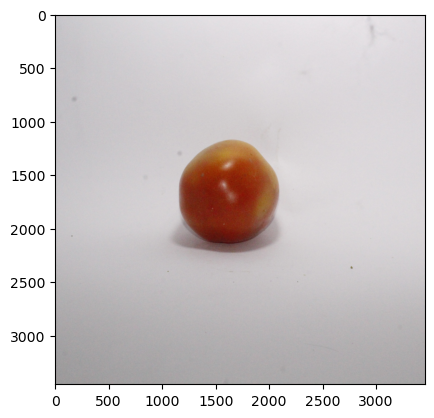

In [40]:
img_viz(df, 40)

In [10]:
def crop_center(img, ratio=0.8):
    h, w = img.shape[:2]
    ch, cw = int(h * ratio), int(w * ratio)
    y1 = (h - ch) // 2
    x1 = (w - cw) // 2
    return img[y1:y1+ch, x1:x1+cw]

In [41]:
def apply_clahe(img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    clahe = cv2.createCLAHE(clipLimit=1.2, tileGridSize=(8,8))
    cl = clahe.apply(l)

    limg = cv2.merge((cl, a, b))
    return cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

In [12]:
def segment_object(img):
    grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thr = cv2.adaptiveThreshold(
        grey, 255, 
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        51, 5
    )
    kernel = np.ones((5,5), np.uint8)
    morph = cv2.morphologyEx(thr, cv2.MORPH_CLOSE, kernel)
    return morph

In [42]:
def preprocessing_basic(img_list):
    result = []
    for img, label in img_list:
        
        cropped = crop_center(img)
        resized = cv2.resize(cropped, (224, 224))
        clahe = apply_clahe(resized)
        seg_mask = segment_object(clahe)   

        # final_img = clahe * (seg_mask > 0)

        result.append((clahe, label))
    
    return result


In [43]:
basic = preprocessing_basic(df)

Shape	: (224, 224, 3)
Label	: Sayur Buah


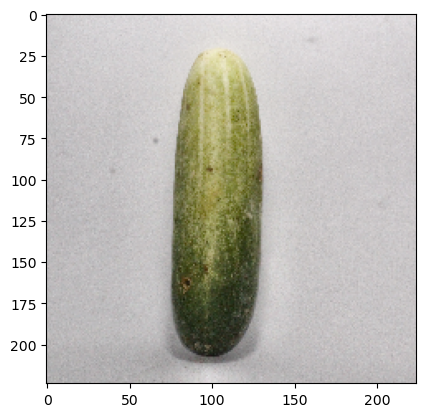

In [44]:
img_viz(basic, 60)

In [14]:
import random

def augment_img(img):
    # Flip horizontal
    if random.random() > 0.5:
        img = cv2.flip(img, 1)

    # Brightness variation
    if random.random() > 0.5:
        factor = 0.5 + random.random()
        img = cv2.convertScaleAbs(img, alpha=factor, beta=10)

    # Rotation small angle
    if random.random() > 0.5:
        h, w = img.shape[:2]
        M = cv2.getRotationMatrix2D((w//2, h//2), random.randint(-15,15), 1)
        img = cv2.warpAffine(img, M, (w, h))

    return img

In [32]:
def apply_augmentation(processed_list, n_aug=2):
    augmented = []

    for img, label in processed_list:
        augmented.append((img, label))  # original

        for _ in range(n_aug):
            aug = augment_img(img.copy())
            augmented.append((aug, label))

    return augmented

In [45]:
aug = apply_augmentation(basic, n_aug=3)

Shape	: (224, 224, 3)
Label	: Sayur Buah


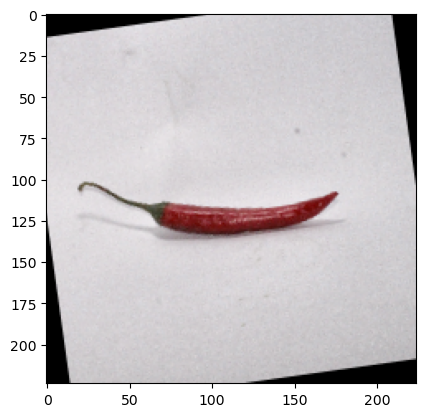

In [46]:
img_viz(aug, 185)

In [47]:
def preprocess_for_HOG(processed_list):
    result = []
    for img, label in processed_list:
        grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(grey, (3,3), 0)
        result.append((blurred, label))
    return result

In [50]:
from skimage.feature import hog

def extract_HOG(img_list):
    features = []
    for img, label in img_list:
        hog_feat = hog(
            img,
            orientations=9,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            block_norm='L2-Hys'
        )
        features.append((hog_feat, label))
    return features


In [53]:
hog_img = preprocess_for_HOG(aug)

Shape	: (224, 224)
Label	: Sayur Akar


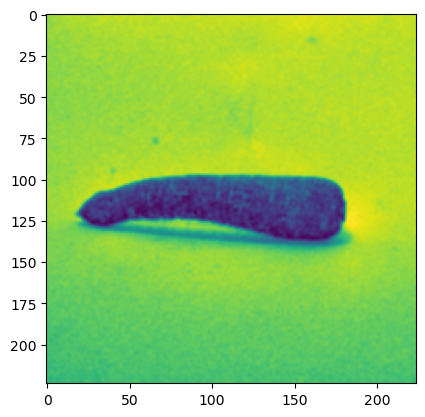

In [54]:
img_viz(hog_img, 100)

In [55]:
hog_feat = extract_HOG(hog_img)

In [56]:
hog_feat

[(array([0.25732834, 0.11517959, 0.14708202, ..., 0.10705001, 0.04819716,
         0.11159153], shape=(26244,)),
  'Sayur Akar'),
 (array([0.25732834, 0.11517959, 0.14708202, ..., 0.10705001, 0.04819716,
         0.11159153], shape=(26244,)),
  'Sayur Akar'),
 (array([0.226897  , 0.10894677, 0.226897  , ..., 0.15300484, 0.1623032 ,
         0.02067307], shape=(26244,)),
  'Sayur Akar'),
 (array([0., 0., 0., ..., 0., 0., 0.], shape=(26244,)), 'Sayur Akar'),
 (array([0.22978651, 0.05085058, 0.14894563, ..., 0.12953586, 0.2431768 ,
         0.20441468], shape=(26244,)),
  'Sayur Akar'),
 (array([0., 0., 0., ..., 0., 0., 0.], shape=(26244,)), 'Sayur Akar'),
 (array([0.25417384, 0.25417384, 0.25417384, ..., 0.08303444, 0.06376014,
         0.04712416], shape=(26244,)),
  'Sayur Akar'),
 (array([0., 0., 0., ..., 0., 0., 0.], shape=(26244,)), 'Sayur Akar'),
 (array([0.25233658, 0.17241237, 0.05889547, ..., 0.08975475, 0.08565371,
         0.03738255], shape=(26244,)),
  'Sayur Akar'),
 (array

In [48]:
def preprocess_for_HSV(processed_list):
    result = []
    for img, label in processed_list:
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        result.append((hsv, label))
    return result

In [52]:
import numpy as np

def extract_HSV_hist(img_list, bins=(8, 8, 8)):
    features = []
    for img, label in img_list:

        hist = cv2.calcHist(
            [img],
            [0, 1, 2],    # H, S, V channel
            None,
            bins,
            [0, 180, 0, 256, 0, 256]
        )

        hist = cv2.normalize(hist, hist).flatten()
        features.append((hist, label))

    return features


In [57]:
hsv_img = preprocess_for_HSV(aug)

Shape	: (224, 224, 3)
Label	: Sayur Akar


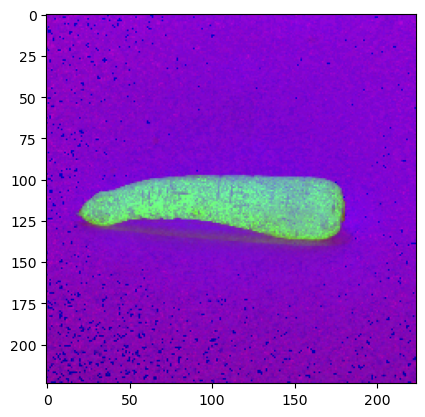

In [58]:
img_viz(hsv_img, 100)

In [59]:
hsv_feat = extract_HSV_hist(hsv_img)

In [60]:
hsv_feat

[(array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         1.3327195e-04, 1.6747842e-02, 4.0470250e-02, 8.4405573e-04,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e

In [49]:
def preprocess_for_GLCM(processed_list):
    result = []
    for img, label in processed_list:
        grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        result.append((grey, label))
    return result

In [51]:
from skimage.feature import graycomatrix, graycoprops
import numpy as np

def extract_GLCM(img_list):
    features = []

    distances = [1, 2]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]

    for img, label in img_list:
        glcm = graycomatrix(img, distances=distances, angles=angles, symmetric=True, normed=True)

        contrast = graycoprops(glcm, 'contrast').flatten()
        homogeneity = graycoprops(glcm, 'homogeneity').flatten()
        energy = graycoprops(glcm, 'energy').flatten()
        correlation = graycoprops(glcm, 'correlation').flatten()

        glcm_feat = np.hstack([contrast, homogeneity, energy, correlation])
        features.append((glcm_feat, label))

    return features


In [61]:
glcm_img = preprocess_for_GLCM(aug)

Shape	: (224, 224)
Label	: Sayur Akar


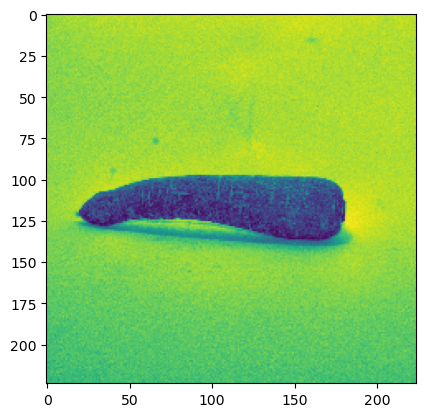

In [62]:
img_viz(glcm_img, 100)

In [63]:
glcm_feat = extract_GLCM(glcm_img)

In [64]:
glcm_feat

[(array([8.01307055e+01, 1.02216936e+02, 8.06537876e+01, 8.47592753e+01,
         1.17742841e+02, 1.02216936e+02, 1.23919281e+02, 8.47592753e+01,
         1.97867425e-01, 1.90578196e-01, 1.94716888e-01, 1.87628588e-01,
         1.88586014e-01, 1.90578196e-01, 1.83095954e-01, 1.87628588e-01,
         3.72572124e-02, 3.65232918e-02, 3.63448759e-02, 3.48335928e-02,
         3.53391653e-02, 3.65232918e-02, 3.42480917e-02, 3.48335928e-02,
         9.71554875e-01, 9.63791801e-01, 9.71324247e-01, 9.69975838e-01,
         9.58359525e-01, 9.63791801e-01, 9.56039873e-01, 9.69975838e-01]),
  'Sayur Akar'),
 (array([8.01307055e+01, 1.02216936e+02, 8.06537876e+01, 8.47592753e+01,
         1.17742841e+02, 1.02216936e+02, 1.23919281e+02, 8.47592753e+01,
         1.97867425e-01, 1.90578196e-01, 1.94716888e-01, 1.87628588e-01,
         1.88586014e-01, 1.90578196e-01, 1.83095954e-01, 1.87628588e-01,
         3.72572124e-02, 3.65232918e-02, 3.63448759e-02, 3.48335928e-02,
         3.53391653e-02, 3.65232

In [67]:
print(f"hog_feat shape: {len(hog_feat)} samples")
print(f"hog_feat[0][0] shape: {hog_feat[0][0].shape}")  # shape of feature vector

print(f"\nhsv_feat shape: {len(hsv_feat)} samples")
print(f"hsv_feat[0][0] shape: {hsv_feat[0][0].shape}")  # shape of feature vector

print(f"\nglcm_feat shape: {len(glcm_feat)} samples")
print(f"glcm_feat[0][0] shape: {glcm_feat[0][0].shape}")  # shape of feature vector

print(f"\ny shape: {y.shape}")

hog_feat shape: 548 samples
hog_feat[0][0] shape: (26244,)

hsv_feat shape: 548 samples
hsv_feat[0][0] shape: (512,)

glcm_feat shape: 548 samples
glcm_feat[0][0] shape: (32,)

y shape: (548,)


In [68]:
# Extract features and labels from each feature list
hog_features = np.array([feat[0] for feat in hog_feat])
hsv_features = np.array([feat[0] for feat in hsv_feat])
glcm_features = np.array([feat[0] for feat in glcm_feat])
labels = np.array([feat[1] for feat in hog_feat])

# Combine all features horizontally
combined_features = np.hstack([hog_features, hsv_features, glcm_features])

# Create dataframe
df_features = pd.DataFrame(combined_features)
df_features['label'] = labels

print(f"Combined dataframe shape: {df_features.shape}")
print(f"Total rows: {len(df_features)}")
print(f"Features columns: {combined_features.shape[1]}")
print(df_features.head())

Combined dataframe shape: (548, 26789)
Total rows: 548
Features columns: 26788
          0         1         2         3         4         5         6  \
0  0.257328  0.115180  0.147082  0.209308  0.138019  0.115912  0.083652   
1  0.257328  0.115180  0.147082  0.209308  0.138019  0.115912  0.083652   
2  0.226897  0.108947  0.226897  0.109092  0.226897  0.226897  0.226897   
3  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4  0.229787  0.050851  0.148946  0.066457  0.182802  0.094285  0.142181   

          7         8         9  ...     26779     26780     26781     26782  \
0  0.141267  0.100538  0.257328  ...  0.034834  0.971555  0.963792  0.971324   
1  0.141267  0.100538  0.257328  ...  0.034834  0.971555  0.963792  0.971324   
2  0.049428  0.034951  0.221048  ...  0.036523  0.971555  0.969976  0.971324   
3  0.000000  0.000000  0.701925  ...  0.059036  0.974602  0.950963  0.974935   
4  0.082454  0.118473  0.229787  ...  0.034699  0.965965  0.958131  0.

In [73]:
X = df_features.drop('label', axis=1).values
y = df_features['label'].values

In [74]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [75]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_encoded
)

In [76]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [77]:
X_train_scaled

array([[ 0.48975017,  0.19452228,  0.36147562, ..., -1.13019542,
         0.74118177, -1.63514371],
       [ 0.47206691, -0.60434577, -0.22378038, ...,  1.64049671,
         1.54680665,  1.68342235],
       [ 0.3777857 ,  0.24149893,  1.35667246, ..., -0.55324903,
         1.14475901, -0.19646972],
       ...,
       [ 0.11283096, -0.06180027,  0.3324987 , ..., -1.92556973,
        -3.07189685, -1.14771517],
       [ 0.46725203,  0.24240155, -0.70353907, ..., -1.18012713,
        -1.37993197, -1.12808904],
       [-1.11251022, -0.89074726, -0.95945095, ...,  1.13620409,
         0.97010091,  1.0102684 ]], shape=(438, 26788))

In [78]:
from sklearn.manifold import MDS
n_components = 50  

print(f"Reducing from {X_train_scaled.shape[1]} to {n_components} dimensions...")

mds = MDS(n_components=n_components, random_state=42, n_jobs=-1, verbose=0)
X_train_reduced = mds.fit_transform(X_train_scaled)
X_test_reduced = mds.fit_transform(X_test_scaled) 

print(f"Reduced shape: {X_train_reduced.shape}")

Reducing from 26788 to 50 dimensions...


C:\Users\innam\AppData\Roaming\Python\Python313\site-packages\sklearn\manifold\_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(
C:\Users\innam\AppData\Roaming\Python\Python313\site-packages\sklearn\manifold\_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


Reduced shape: (438, 50)



Visualizing first 2 components...


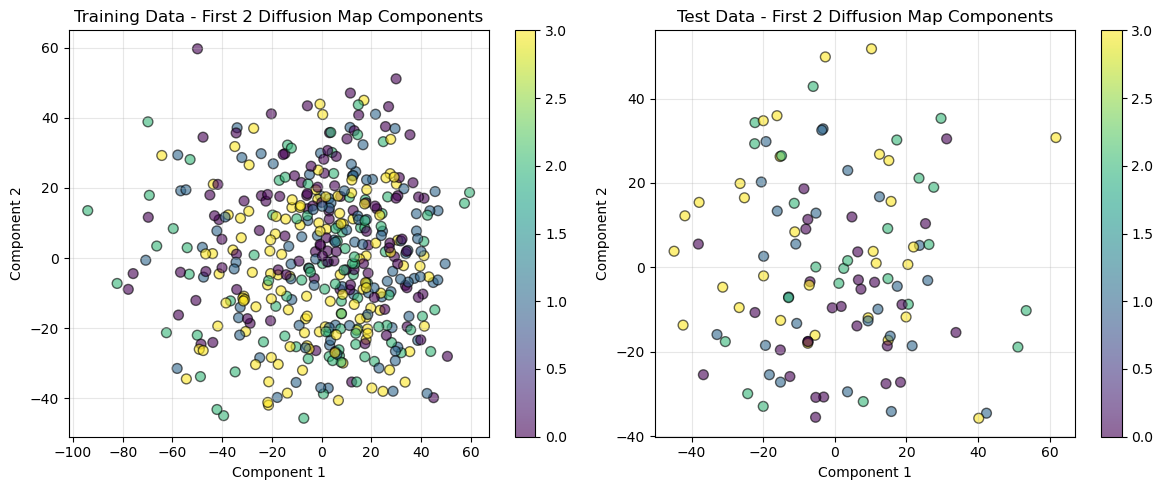

In [79]:
print("\nVisualizing first 2 components...")
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
scatter = plt.scatter(X_train_reduced[:, 0], X_train_reduced[:, 1], 
                     c=y_train, cmap='viridis', alpha=0.6, edgecolors='k', s=50)
plt.colorbar(scatter)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Training Data - First 2 Diffusion Map Components')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
scatter = plt.scatter(X_test_reduced[:, 0], X_test_reduced[:, 1], 
                     c=y_test, cmap='viridis', alpha=0.6, edgecolors='k', s=50)
plt.colorbar(scatter)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Test Data - First 2 Diffusion Map Components')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [89]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
    'kernel': ['rbf']
}


print("Parameter grid:")
for param, values in param_grid.items():
    print(f"  - {param}: {values}")

svm = SVC(random_state=42)
grid_search = GridSearchCV(
    svm, 
    param_grid, 
    cv=5, 
    scoring='accuracy', 
    n_jobs=-1, 
    verbose=2,
    return_train_score=True
)

grid_search.fit(X_train_scaled, y_train)

print("\n" + "="*70)
print("GRID SEARCH RESULTS")
print("="*70)
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
print(f"Total combinations tested: {len(grid_search.cv_results_['params'])}")

best_model = grid_search.best_estimator_

cv_results = pd.DataFrame(grid_search.cv_results_)
top_5 = cv_results.nlargest(5, 'mean_test_score')[
    ['params', 'mean_test_score', 'std_test_score', 'rank_test_score']
]
print("\nTop 5 parameter combinations:")
print(top_5.to_string(index=False))

Parameter grid:
  - C: [0.1, 1, 10, 100]
  - gamma: ['scale', 'auto', 0.001, 0.01, 0.1, 1]
  - kernel: ['rbf']
Fitting 5 folds for each of 24 candidates, totalling 120 fits

GRID SEARCH RESULTS
Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation score: 0.8926
Total combinations tested: 24

Top 5 parameter combinations:
                                       params  mean_test_score  std_test_score  rank_test_score
 {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}         0.892581         0.03250                1
  {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}         0.892581         0.03250                1
{'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}         0.892581         0.03250                1
 {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}         0.892581         0.03250                1
  {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}         0.871970         0.04712                5


In [90]:
from sklearn.metrics import classification_report
y_pred = best_model.predict(X_test_scaled)
print("\n" + "="*70)
print("CLASSIFICATION REPORT")
print("="*70)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


CLASSIFICATION REPORT
              precision    recall  f1-score   support

  Sayur Akar       0.96      0.90      0.93        29
  Sayur Buah       1.00      0.92      0.96        26
 Sayur Bunga       0.90      0.79      0.84        24
  Sayur Daun       0.82      1.00      0.90        31

    accuracy                           0.91       110
   macro avg       0.92      0.90      0.91       110
weighted avg       0.92      0.91      0.91       110



In [91]:
train_acc = best_model.score(X_train_scaled, y_train)
test_acc = best_model.score(X_test_scaled, y_test)
print("\n" + "="*70)
print("FINAL MODEL ACCURACY")
print("="*70)
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


FINAL MODEL ACCURACY
Training Accuracy: 1.0000
Test Accuracy: 0.9091


In [92]:
import joblib

joblib.dump(best_model, 'svm_kategori_sayur_model.joblib')

['svm_kategori_sayur_model.joblib']